# Classifying Fashion-MNIST

Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict

import helper

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, 
                                 transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, 
                                transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

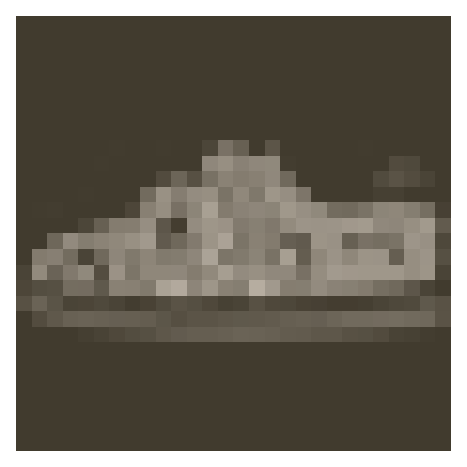

In [3]:
# an image from data set
image, label = next(iter(trainloader)); helper.imshow(image[0,:]);

## Building the network

Each image is 28x28 which is a total of 784 pixels, and there are 10 classes. Use ReLU activations for the layers and to return log-softmax from the forward pass. 

In [4]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # make sure input tensor is flattened (vector)
        x = x.view(x.shape[0], -1)
        # Flatten images into a 784 long vector
        #images.resize_(images.size()[0], 784)
        
        #Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        x = self.output(x)
        return F.log_softmax(x, dim=1)    

In [5]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy

# Train the network

Since the model's forward method returns the log-softmax, I used the [negative log loss](http://pytorch.org/docs/master/nn.html#nllloss) as my criterion, `nn.NLLLoss()`. I also chose to use the [Adam optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Adam). This is a variant of stochastic gradient descent which includes momentum and in general trains faster than your basic SGD.

I've also included a block to measure the validation loss and accuracy. Since I'm using dropout in the network, I need to turn it off during inference. Otherwise, the network will appear to perform poorly because many of the connections are turned off. PyTorch allows you to set a model in "training" or "evaluation" modes with `model.train()` and `model.eval()`, respectively. In training mode, dropout is turned on, while in evaluation mode, dropout is turned off. This effects other modules as well that should be on during training but off during inference.

The validation code consists of a forward pass through the validation set (also split into batches). With the log-softmax output, I calculate the loss on the validation set, as well as the prediction accuracy.

In [6]:
#Create the network, define the criterion and optimizer
model = Network(784, 10, [256, 128, 64], drop_p=0.2)
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [7]:
# TODO: Train the network here
epochs = 30

train_losses, test_losses, accuracy_step = [], [], []
t0 = time()

for e in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
            # Make sure network is in eval mode for inference
            model.eval()
            test_loss, accuracy = validation(model, testloader, criterion)            
          
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracy_step.append(accuracy/len(testloader))
        
        if e % (epochs / 10) == 0:
            print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
        running_loss = 0
        # Set model back to train mode
        model.train()
print('Tempo total para treino: ', round((time()-t0)/60,3), ' min')                  

Epoch: 1/30..  Training Loss: 0.611..  Test Loss: 0.458..  Test Accuracy: 0.835
Epoch: 4/30..  Training Loss: 0.434..  Test Loss: 0.400..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.399..  Test Loss: 0.386..  Test Accuracy: 0.862
Epoch: 10/30..  Training Loss: 0.385..  Test Loss: 0.386..  Test Accuracy: 0.864
Epoch: 13/30..  Training Loss: 0.376..  Test Loss: 0.392..  Test Accuracy: 0.866
Epoch: 16/30..  Training Loss: 0.371..  Test Loss: 0.386..  Test Accuracy: 0.863
Epoch: 19/30..  Training Loss: 0.366..  Test Loss: 0.395..  Test Accuracy: 0.865
Epoch: 22/30..  Training Loss: 0.357..  Test Loss: 0.397..  Test Accuracy: 0.867
Epoch: 25/30..  Training Loss: 0.350..  Test Loss: 0.371..  Test Accuracy: 0.872
Epoch: 28/30..  Training Loss: 0.340..  Test Loss: 0.389..  Test Accuracy: 0.870
Tempo total para treino:  9.699  min


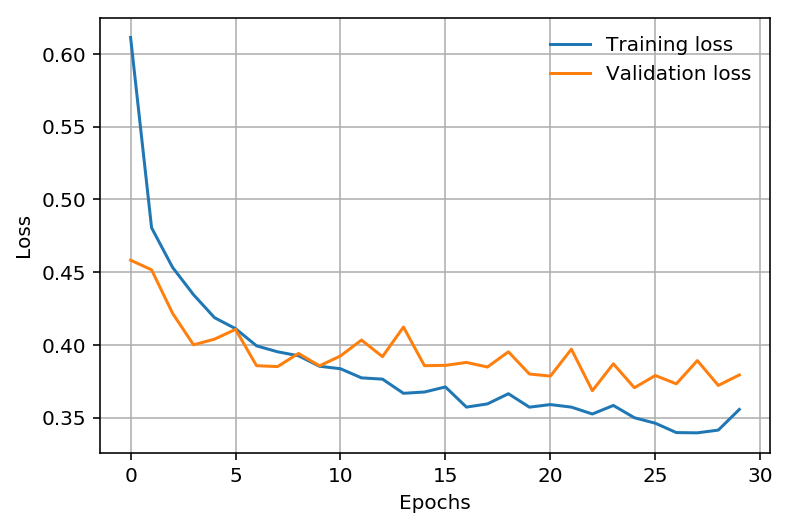

In [9]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Validation loss')
plt.legend(frameon = False)
plt.xlabel('Epochs'); plt.ylabel('Loss');
plt.grid(axis='both');

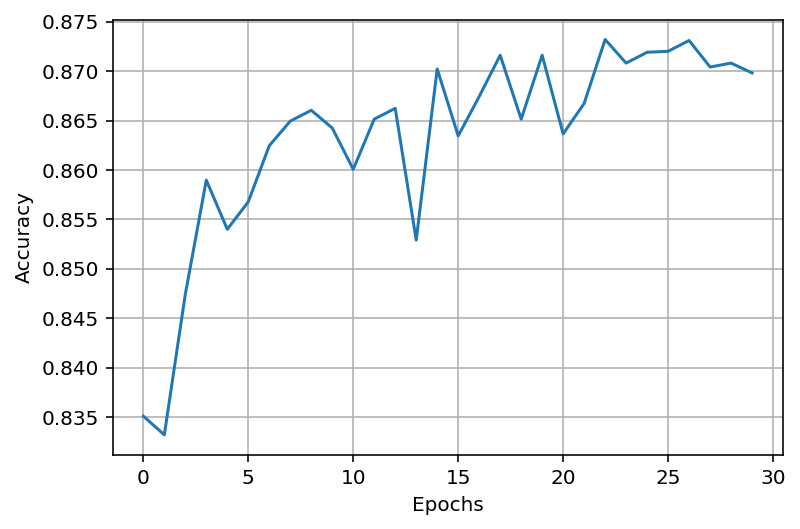

In [10]:
plt.plot(accuracy_step)
plt.xlabel('Epochs'); plt.ylabel('Accuracy');
plt.grid(axis='both');

# Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

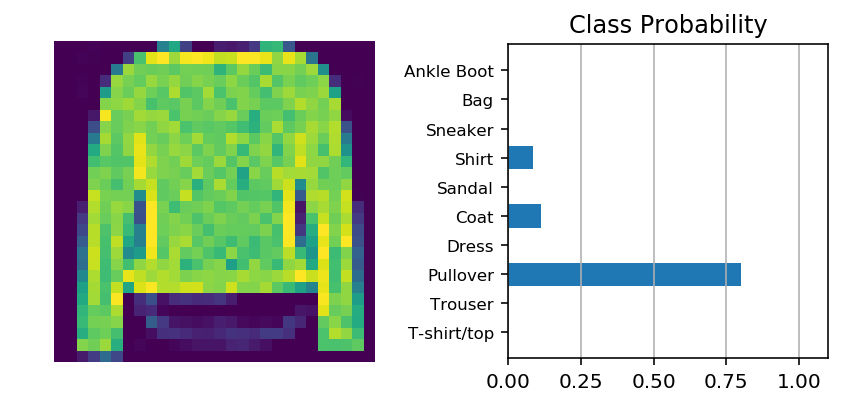

In [11]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

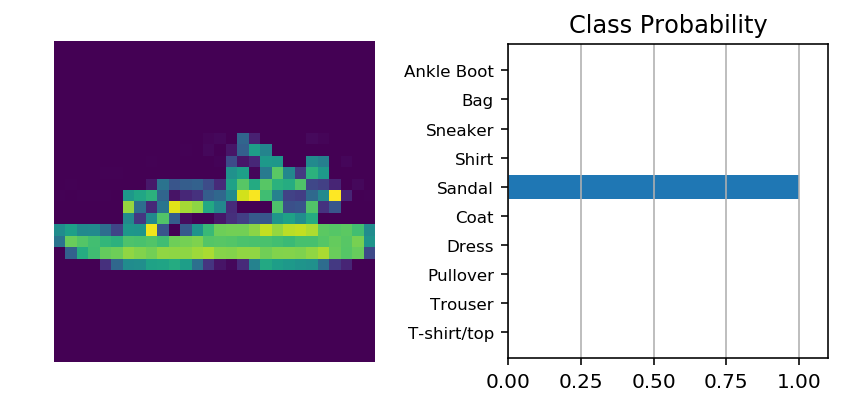

In [25]:
# one way to select a data to infer
images, labels = next(iter(trainloader))
img = images[0].view(1, 784)
ps = torch.exp(model(img))
helper.view_classify(img.view(1,28,28), ps, version='Fashion')

# Saving network model

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [13]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [14]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'F_MNIST_checkpoint.pth')